In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import ndimage
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score

from utils import *
from model_FCNN import generate_model


Using TensorFlow backend.


In [2]:
from importlib import reload

import keras
reload(keras)
from keras import backend as K

import utils
reload(utils)
from utils import *

import model_FCNN
reload(model_FCNN)
from model_FCNN import generate_model

import callback_custom
reload(callback_custom);

# Problem configuration

In [3]:
num_classes = 11
num_channel = 2

# K-fold validation (K=5)
n_training = 16
n_test = 4

#idxs_training = list(range(1, 1+16))
#idxs_test = list(range(17, 17+4))
idxs_training = list(range(1, 1+8)) + list(range(13, 13+8))
idxs_test = list(range(9,9+4))

patience = 5
model_filename = 'models/outrun_step_{}.h5'
csv_filename = 'log/outrun_step_{}.cvs'

nb_epoch = 40
validation_split = 0.10
monitor = 'val_loss'#'val_categorical_accuracy'

class_mapper = {0:0}
class_mapper.update({ i+1:i for i in range(1, 1+10) })
class_mapper_inv = {0:0}
class_mapper_inv.update({ i:i+1 for i in range(1, 1+10) })

matrix_size = (160, 220, 48)

extraction_step = (3, 3, 1)
#extraction_step = (5, 5, 3)

segment_size = (27, 27, 21)
core_size = (9, 9, 3)

# Architecture

# 1. Initial segmentation

## 1.1 Read data

In [4]:
QSM_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
MAG_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
R2S_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
label_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_training):
    QSM_train[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_train[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_train[i, :, :, :] = read_data(case_idx, 'R2S')
    label_train[i, :, :, :] = read_data(case_idx, 'label')

In [5]:
#data_train = np.stack((QSM_train, MAG_train, R2S_train), axis = 1)
data_train = np.stack((QSM_train, R2S_train), axis = 1)
#data_train = np.stack((QSM_train,), axis = 1)

In [6]:
QSM_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
MAG_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
R2S_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
label_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_test):
    QSM_test[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_test[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_test[i, :, :, :] = read_data(case_idx, 'R2S')
    label_test[i, :, :, :] = read_data(case_idx, 'label')

In [7]:
#data_test = np.stack((QSM_test, MAG_test, R2S_test), axis = 1)
data_test = np.stack((QSM_test, R2S_test), axis = 1)
#data_test = np.stack((QSM_test,), axis = 1)

## 1.2 Pre-processing

In [8]:
## Intensity normalisation (zero mean and unit variance)
input_mean = 127.0
input_std = 128.0
data_train = (data_train - input_mean) / input_std
data_test = (data_test - input_mean) / input_std

# Map class label
tmp = np.copy(label_train)
for class_idx in class_mapper:
    label_train[tmp == class_idx] = class_mapper[class_idx]
tmp = np.copy(label_test)
for class_idx in class_mapper:
    label_test[tmp == class_idx] = class_mapper[class_idx]
del tmp

In [9]:
label_train.max()

10.0

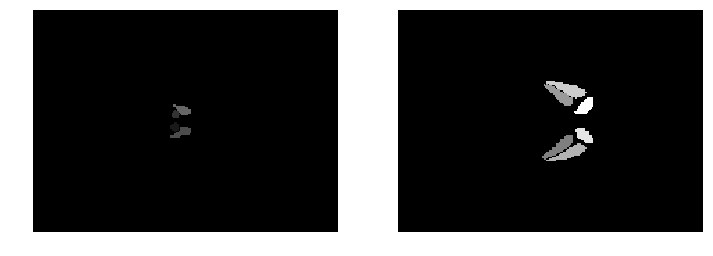

In [10]:
plots(np.squeeze(label_train[0,:,:,[29,25]]), scale = (0, 10))

## 1.3 Data preparation

In [11]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((33591, 2, 27, 27, 21), (33591, 243, 11))

In [12]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

## 1.4 Configure callbacks

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('1'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

## 1.5 Training

In [14]:
seed = 47
np.random.seed(seed)

# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

K.set_value(model.optimizer.lr, 1e-3)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 30231 samples, validate on 3360 samples
Epoch 1/40
30231/30231 [==============================] - 187s 6ms/step - loss: 0.3914 - categorical_accuracy: 0.8774 - val_loss: 0.2578 - val_categorical_accuracy: 0.9208
Epoch 2/40
30231/30231 [==============================] - 186s 6ms/step - loss: 0.0902 - categorical_accuracy: 0.9628 - val_loss: 0.3923 - val_categorical_accuracy: 0.9211
Epoch 3/40
30231/30231 [==============================] - 186s 6ms/step - loss: 0.0427 - categorical_accuracy: 0.9827 - val_loss: 0.4559 - val_categorical_accuracy: 0.9235
Epoch 4/40
30231/30231 [==============================] - 187s 6ms/step - loss: 0.0278 - categorical_accuracy: 0.9893 - val_loss: 0.5318 - val_categorical_accuracy: 0.9263
Epoch 5/40
30231/30231 [==============================] - 188s 6ms/step - loss: 0.0117 - categorical_accuracy: 0.9958 - val_loss: 0.6242 - val_categorical_accuracy: 0.9221
Epoch 6/40
30231/30231 [==============================] - 189s 6ms/step - loss: 0.0217 - ca

## 1.6 Classification

In [15]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format(1))

In [16]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

3359/3359 [==============================] - 3s 842us/step


[0.25783444805740069, 0.92078507255322528]

In [17]:
len_patch = extract_patches(read_data(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [18]:
segmentations_train = []

for i_case, case_idx in enumerate(idxs_training):

    print(case_idx)
    input_train = data_train[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_train[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_train = segmentations_train + [segmentation]
    
segmentations_train = np.stack(segmentations_train, axis=0)

1
3300/3300 [==============================] - 3s 808us/step
2
3300/3300 [==============================] - 3s 776us/step
3
3300/3300 [==============================] - 3s 774us/step
4
3300/3300 [==============================] - 3s 766us/step
5
3300/3300 [==============================] - 3s 765us/step
6
3300/3300 [==============================] - 3s 772us/step
7
3300/3300 [==============================] - 3s 771us/step
8
3300/3300 [==============================] - 3s 783us/step
13
3300/3300 [==============================] - 3s 777us/step
14
3300/3300 [==============================] - 3s 779us/step
15
3300/3300 [==============================] - 3s 776us/step
16
3300/3300 [==============================] - 3s 777us/step
17
3300/3300 [==============================] - 3s 778us/step
18
3300/3300 [==============================] - 3s 784us/step
19
3300/3300 [==============================] - 3s 790us/step
20
3300/3300 [==============================] - 3s 793us/step


In [19]:
segmentations_train.max()

10.0

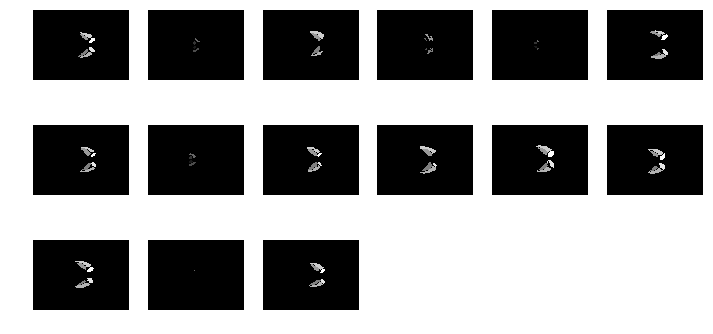

In [20]:
plots(np.squeeze(label_train[0:15,:,:,25]), rows=3, scale = (0, 10))

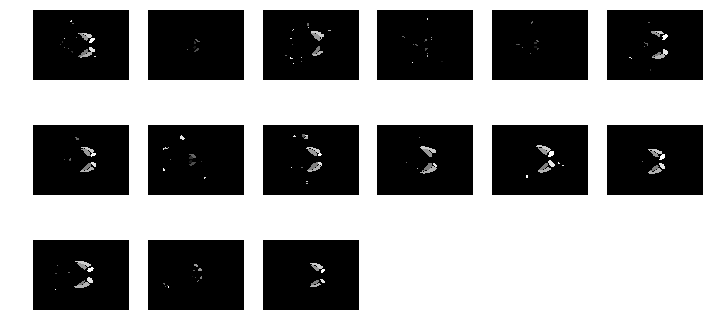

In [21]:
plots(np.squeeze(segmentations_train[0:15,:,:,25]), rows=3, scale = (0, 10))

## 1.7 Check false-positive

In [22]:
idx_fpos = (label_train == 0) & (segmentations_train != 0);

In [23]:
mask_fpos = np.zeros(label_train.shape, dtype=precision_global)
mask_fpos[idx_fpos == True] = 1

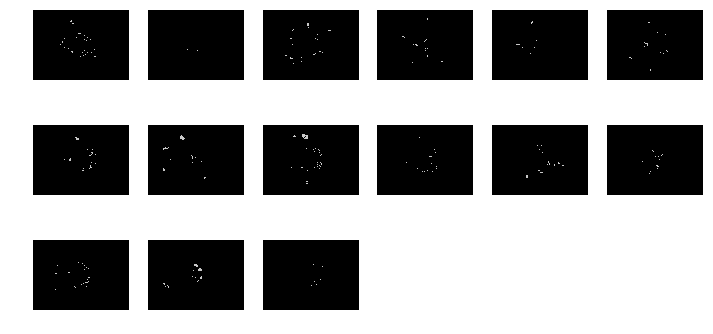

In [24]:
plots(200*(np.squeeze(mask_fpos[0:15,:,:,25])), rows=3)

# 2 Fine-tuning

## 2.2 Rebuild training dataset

In [25]:
del x_train, y_train

In [26]:
extraction_step_ft = (6,6,3)
x_train, y_train = build_set(data_train, label_train, extraction_step_ft, segment_size, core_size, mask_fpos)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((7873, 2, 27, 27, 21), (7873, 243, 11))

In [24]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

In [32]:
save_array('tmp/x_train.bc', x_train)
save_array('tmp/y_train.bc', y_train)

In [4]:
x_train = load_array('tmp/x_train.bc')
y_train = load_array('tmp/y_train.bc')

## 2.3 Regenerate model

In [27]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('2'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

In [28]:
# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

# Load optimized weights
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 7085 samples, validate on 788 samples
Epoch 1/40
7085/7085 [==============================] - 43s 6ms/step - loss: 0.0587 - categorical_accuracy: 0.9772 - val_loss: 0.0035 - val_categorical_accuracy: 0.9990
Epoch 2/40
7085/7085 [==============================] - 42s 6ms/step - loss: 0.0452 - categorical_accuracy: 0.9816 - val_loss: 0.0037 - val_categorical_accuracy: 0.9991
Epoch 3/40
7085/7085 [==============================] - 43s 6ms/step - loss: 0.0405 - categorical_accuracy: 0.9834 - val_loss: 0.0037 - val_categorical_accuracy: 0.9989
Epoch 4/40
7085/7085 [==============================] - 43s 6ms/step - loss: 0.0373 - categorical_accuracy: 0.9845 - val_loss: 0.0021 - val_categorical_accuracy: 0.9993
Epoch 5/40
7085/7085 [==============================] - 43s 6ms/step - loss: 0.0346 - categorical_accuracy: 0.9856 - val_loss: 0.0039 - val_categorical_accuracy: 0.9987
Epoch 6/40
7085/7085 [==============================] - 43s 6ms/step - loss: 0.0322 - categorical_accuracy: 

In [29]:
# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format('2'))

In [30]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

787/787 [==============================] - 1s 1ms/step


[0.0014225059498652929, 0.99955534351826325]

In [31]:
segmentations_test = []

for i_case, case_idx in enumerate(idxs_test):

    print(case_idx)
    input_test = data_test[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_test[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    #segmentation = reconstruct_volume_majority(pred_classes, matrix_size, extraction_step=(3, 3, 3))
    
    segmentations_test = segmentations_test + [segmentation]
    
segmentations_test = np.stack(segmentations_test, axis=0)

9
3300/3300 [==============================] - 3s 792us/step
10
3300/3300 [==============================] - 3s 769us/step
11
3300/3300 [==============================] - 3s 770us/step
12
3300/3300 [==============================] - 3s 762us/step


In [32]:
segmentations_test.max()

10.0

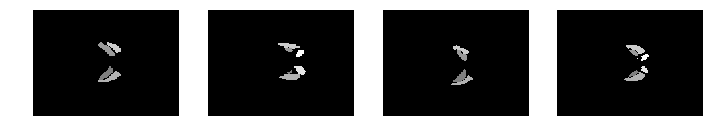

In [33]:
plots(np.squeeze(label_test[:,:,:,23]), rows=1, scale = (0, 10))

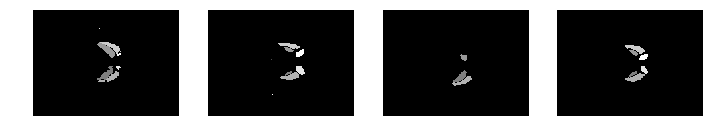

In [34]:
plots(np.squeeze(segmentations_test[:,:,:,23]), rows=1, scale = (0, 10))

# 3 Post-processing

## 3.1 Pick the largest connected component for each class

In [35]:
for i_case, case_idx in enumerate(idxs_test):
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);
    tmp = np.zeros(segmentation.shape, dtype=segmentation.dtype)
    
    for class_idx in class_mapper_inv :
        mask = (segmentation == class_idx)
        
        if class_idx != 0 and mask.sum() > 0:
            labeled_mask, num_cc = ndimage.label(mask)
            largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
            
            tmp[largest_cc_mask == 1] = class_idx
        
    segmentations_test[i_case,:,:,:] = tmp

## 3.2 Save it 

In [36]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx)
    
    segmentation = np.copy(np.squeeze(segmentations_test[i_case,:,:,:]))
    
    tmp = np.copy(segmentation)
    for class_idx in class_mapper_inv:
        segmentation[tmp == class_idx] = class_mapper_inv[class_idx]
    del tmp

    save_data(segmentation, case_idx, 'label')    

print("Done with Step 3")

9
10
11
12
Done with Step 3


## 3.3 Calculate metric 

In [37]:
def calc_dice(m1, m2):
    return 2*((m1==1) & (m2==1)).sum()/((m1==1).sum() + (m2==1).sum())

In [38]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    print('{:.4f}'.format(accuracy_score(label_test[i_case,:,:,:].flat, segmentations_test[i_case,:,:,:].flat)), end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(precision_score(label_test[i_case,:,:,:][mask], segmentations_test[i_case,:,:,:][mask], average='micro')), end='\t')
        else:
            print('N/A', end='\t')
    print()

9	0.9991	N/A	0.7529	0.8125	0.9262	0.9676	0.8361	0.6384	0.9349	0.7836	0.7188	0.8698	
10	0.9991	N/A	0.8980	0.8267	0.7157	0.8270	0.7823	0.7761	0.9162	0.9344	0.7500	0.7332	
11	0.9992	N/A	0.7907	0.8000	0.8798	0.8366	0.8072	0.7675	0.8544	0.8683	0.8719	0.5607	
12	0.9993	N/A	0.8810	0.8750	0.9537	0.9626	0.9884	0.9121	0.8593	0.9251	0.5564	0.5479	


In [39]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(calc_dice((label_test[i_case,:,:,:]==class_idx).flat, (segmentations_test[i_case,:,:,:]==class_idx).flat)), end='\t')
        else:
            print(0, end='\t')
    print()

9	0	0.8312	0.8497	0.7931	0.8775	0.8648	0.7676	0.8671	0.7755	0.7823	0.8931	
10	0	0.8000	0.8493	0.5123	0.7612	0.8467	0.8633	0.8545	0.8747	0.7702	0.7603	
11	0	0.8608	0.8387	0.9096	0.8678	0.8602	0.7497	0.8824	0.6388	0.8624	0.6369	
12	0	0.8506	0.7692	0.7574	0.8996	0.9031	0.9275	0.8417	0.8380	0.6327	0.6830	
